<p><font size="8" color='grey'> <b>
Anwendung Generativer KI
</b></font> </br></p>

<p><font size="6" color='grey'> <b>
Modul 02: Modellansteuerung
</b></font> </br></p>

---

<a target="_blank" href="https://colab.research.google.com/github/ralf-42/GenAI/blob/main/01%20ipynb/M02_Modellansteuerung.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Die rasante Entwicklung im Bereich der künstlichen Intelligenz (KI) hat zu beeindruckenden Fortschritten bei großen Sprachmodellen (LLMs) geführt. Diese Modelle können menschenähnlichen Text generieren, Sprachen übersetzen und komplexe Fragen beantworten. Doch wie genau steuert man diese Modelle, um die gewünschten Ergebnisse zu erzielen? In diesem Modul werden wir drei gängige Methoden der Modellansteuerung untersuchen: Prompting, Retrieval-Augmented Generation (RAG) und Fine-Tuning.



# **1 <font color='orange'>|</font> Überblick**
---


## **Prompting**



Prompting ist die einfachste und direkteste Methode zur Steuerung von LLMs. Dabei wird dem Modell eine Textaufforderung, der sogenannte "Prompt", gegeben, der die gewünschte Ausgabe beschreibt. Die Qualität der Ausgabe hängt stark von der Qualität des Prompts ab. Ein gut formulierter Prompt sollte klar, prägnant und spezifisch sein.

**Funktionsweise:**

+ Der Benutzer gibt einen Prompt in das LLM ein.
+ Das LLM verarbeitet den Prompt und generiert eine Antwort basierend auf seinem Training und den im Prompt enthaltenen Informationen

**Arten von Prompts:**

Es gibt verschiedene Arten von Prompts, die verwendet werden können, um bestimmte Reaktionen vom Modell hervorzurufen:

+ Verbale Prompts: Dies sind gesprochene oder geschriebene Anweisungen. Zum Beispiel: "Schreibe eine kurze Geschichte über eine Katze, die zum Mond fliegt."
+ Visuelle Prompts: Dies können Bilder oder andere visuelle Elemente sein. Zum Beispiel: Ein Bild einer Katze, die in den Weltraum startet, könnte als Prompt für eine Geschichte über eine Katze dienen, die zum Mond fliegt.

**Prompt Chaining:**

Prompt Chaining ist eine Technik, bei der eine Reihe von Prompts verwendet wird, um das Modell durch mehrere Schritte zu führen oder komplexere Ausgaben zu generieren. Zum Beispiel könnte ein erster Prompt das Modell anweisen, eine Liste von Themen zu generieren, ein zweiter Prompt es dann auffordern, eines dieser Themen auszuwählen und einen Aufsatz darüber zu schreiben.

**Einsatzszenarien:**

Prompting eignet sich besonders für Aufgaben, die schnell und flexibel erledigt werden müssen, wie z. B.:

+ Textgenerierung
+ Übersetzung
+ Zusammenfassung
+ Brainstorming
+ Beantwortung allgemeiner Fragen
+ ...

## **RAG**

RAG (Retrieval-Augmented Generation) ist eine hybride Methode, die die Stärken von LLMs mit denen von Information-Retrieval-Systemen kombiniert. Dabei greift das LLM auf externe Wissensdatenbanken zu, um seine Antworten zu verbessern und die Probleme von Halluzinationen und veralteten Informationen zu mindern.

**Funktionsweise:**

+ Der Benutzer gibt eine Anfrage in das RAG-System ein.
+ Das System sucht mithilfe von Embedding Language Models und Vektor Datenbanken in externen Wissensdatenbanken nach relevanten Informationen.
+ Die relevanten Informationen werden dem LLM als Kontext bereitgestellt.
+ Das LLM generiert eine Antwort basierend auf der Anfrage und dem Kontext.


**Einsatzszenarien:**

RAG eignet sich besonders für Aufgaben, die aktuelle oder domänenspezifische Informationen erfordern, wie z. B.:

+ Kundensupport mit Zugriff auf Produktdatenbanken
+ Medizinische Diagnose mit Zugriff auf aktuelle Forschungsergebnisse
+ Finanzplanung mit Zugriff auf Marktdaten
+ Beantwortung von Fragen zu Unternehmensinformationen



## **Fine-Tuning**

Fine-Tuning ist eine Methode, bei der ein bereits trainiertes LLM auf einer kleineren, aufgabenspezifischen Datenmenge weiter trainiert wird. Dadurch kann das Modell an spezifische Anforderungen angepasst und seine Leistung für diese Aufgaben verbessert werden.

**Funktionsweise:**

+ Ein vortrainiertes LLM wird ausgewählt.
+ Eine aufgabenspezifische Datenmenge wird vorbereitet.
+ Das LLM wird auf dieser Datenmenge weiter trainiert.
+ Die Parameter des LLM werden angepasst, um die Leistung für die spezifische Aufgabe zu optimieren.

**Methoden des Fine-Tunings:**

Es gibt verschiedene Methoden, um ein LLM zu fine-tunen:

+ Instruction Fine-Tuning: Das Modell wird mit Beispielen trainiert, die zeigen, wie es auf bestimmte Anfragen reagieren soll. Zum Beispiel könnte man dem Modell Anweisungen wie "Fasse diesen Text zusammen" geben, gefolgt von dem eigentlichen Text.
+ Weitere Methoden: Es gibt noch weitere Fine-Tuning-Methoden, die je nach Anwendungsfall und Zielsetzung eingesetzt werden können.


**Einsatzszenarien:**

Fine-Tuning eignet sich besonders für Aufgaben, die eine hohe Genauigkeit und Domänenspezialisierung erfordern, wie z. B.:

+ Sentimentanalyse
+ Textklassifizierung
+ Spam-Erkennung
+ Personalisierte Kundeninteraktionen




# **2 <font color='orange'>|</font> Entscheidungskriterien**
---

Die Wahl der geeigneten Methode hängt von verschiedenen Faktoren ab, darunter:


| Kriterium | Prompting | RAG | Fine-Tuning |
|-----------|-----------|-----|-------------|
| **Komplexität** | Niedrig<br><br>Die Implementierung ist <br>einfach und erfordert keine <br>Änderungen am Modell. | Mittel<br><br>RAG erfordert die Integration<br>von Retrieval-Mechanismen<br>und einer Wissensdatenbank. | Hoch<br><br>Fine-Tuning beinhaltet<br>einen komplexeren Prozess<br>des weiteren Trainings. |
| **Effizienz** | Hoch<br><br>Prompting ermöglicht eine<br>schnelle und flexible<br>Interaktion mit dem Modell. | Mittel<br><br>RAG benötigt zusätzliche<br>Schritte für den Datenabruf,<br>was die Effizienz mindert. | Niedrig<br><br>Fine-Tuning ist rechen-<br>intensiv und zeitaufwendig. |
| **Genauigkeit** | Niedrig<br><br>Die Genauigkeit hängt stark<br>von der Qualität des<br>Prompts ab. | Mittel<br><br>RAG bietet höhere<br>Genauigkeit durch externe<br>Informationen. | Hoch<br><br>Führt zu höherer<br>Genauigkeit bei<br>spezifischen Aufgaben. |
| **Flexibilität** | Hoch<br><br>Sehr flexibel und für<br>verschiedene Aufgaben<br>einsetzbar. | Mittel<br><br>Flexibler als Fine-Tuning,<br>aber weniger flexibel als<br>Prompting. | Niedrig<br><br>Ist auf bestimmte Aufgaben<br>spezialisiert und weniger<br>anpassungsfähig. |
| **Ressourcen-<br>bedarf** | Niedrig<br><br>Benötigt nur minimale<br>Ressourcen für die<br>Ausführung. | Mittel<br><br>Ressourcen für Datenbank-<br>verwaltung und Retrieval<br>erforderlich. | Hoch<br><br>Erfordert erhebliche<br>Rechenleistung und Zeit<br>für Training. |
| **Datenbedarf** | Niedrig<br><br>Keine zusätzlichen<br>Trainingsdaten<br>erforderlich. | Mittel<br><br>Benötigt Wissensdatenbank<br>mit relevanten<br>Informationen. | Hoch<br><br>Benötigt große Mengen an<br>spezifischen<br>Trainingsdaten. |
| **Beschreibung** | Einfache Methode mit<br>Textanweisungen für das<br>Modell. | Kombination von LLMs mit<br>Information-Retrieval-<br>Systemen. | Weiteres Training des<br>Modells auf spezifischen<br>Datensätzen. |




# **3 <font color='orange'>|</font> Trade-offs**
---



Bei der Wahl zwischen den verschiedenen Modellansteuerungstechniken gibt es immer Trade-offs, die berücksichtigt werden müssen:

- **Kosteneffizienz**: Fine-Tuning ist kostspieliger, da es nicht nur erhebliche Rechenressourcen erfordert, sondern auch Zeit, um ein Modell zu trainieren. RAG bietet einen Mittelweg, da es externe Daten nutzt, ohne dass ein vollständiges Modell neu trainiert werden muss. Prompting ist hingegen am kostengünstigsten, da es keine zusätzlichen Trainingsphasen erfordert.

- **Flexibilität**: Fine-Tuning bietet die höchste Flexibilität, da es das Modell vollständig an die speziellen Anforderungen anpassen kann. RAG bietet ebenfalls Flexibilität, allerdings hängt die Qualität der Ergebnisse stark von der Qualität der externen Daten ab. Prompting ist flexibler in der Formulierung der Anfragen, hat jedoch in komplexen Szenarien oft Einschränkungen in der Präzision und Tiefe der Antworten.

- **Generalität vs. Spezifität**: Modelle, die nur mit Prompting betrieben werden, sind in der Regel allgemeiner und weniger präzise in der Bearbeitung spezifischer Anfragen. Fine-Tuning ermöglicht die Anpassung an spezifische Anforderungen, reduziert jedoch die Generalisierbarkeit auf andere Domänen. RAG bietet eine Balance, da es externe Daten zur Verbesserung der Antwortqualität verwendet, ohne die Generalität des zugrundeliegenden Modells zu stark zu beeinflussen.




# **4 <font color='orange'>|</font> Aktuelle Trends**
---

Im Bereich der Modellansteuerung gibt es einige aktuelle Trends und Entwicklungen:

**Prompting:**

+ Multimodales Prompting: LLMs werden in die Lage versetzt, mit verschiedenen Datenformaten wie Bildern, Videos und Ton umzugehen.
+ Ethische Aspekte: Es wird verstärkt Wert auf die Vermeidung von Verzerrungen und die Förderung von Fairness und Inklusivität in den Antworten gelegt.

**RAG:**

+ Produktionsreife RAG-Systeme: Der Fokus liegt auf der Entwicklung von robusten und skalierbaren RAG-Systemen für den Einsatz in Unternehmen.
+ Datenschutz und Sicherheit: Es werden neue Methoden entwickelt, um den Datenschutz und die Sicherheit von RAG-Systemen zu gewährleisten.

**Fine-Tuning:**

+ Skalierbarkeit: Es werden neue Techniken entwickelt, um das Fine-Tuning von immer größeren Modellen zu ermöglichen.
+ Effizienz: Es wird an Methoden geforscht, um den Ressourcenbedarf für das Fine-Tuning zu reduzieren.



# **5 <font color='orange'>|</font> Fazit**
---

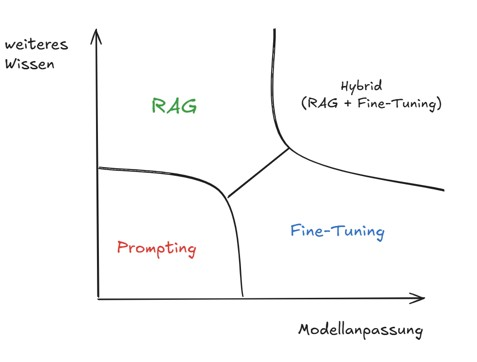

Prompting, RAG und Fine-Tuning sind drei wichtige Methoden zur Steuerung von LLMs. Jede Methode hat ihre eigenen Stärken und Schwächen und eignet sich für unterschiedliche Einsatzszenarien. Die Wahl der besten Methode hängt von den spezifischen Anforderungen der jeweiligen Aufgabe ab. Aktuelle Trends und Entwicklungen zielen darauf ab, die Effizienz, Genauigkeit und Skalierbarkeit dieser Methoden zu verbessern und ethische Aspekte stärker zu berücksichtigen. In der Praxis werden die einzelnen Ansätze oft in Kombination eingesetzt.


